In [117]:
%load_ext autoreload
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [118]:
import os,sys,glob
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import pickle 

from scipy.ndimage.filters import gaussian_filter,convolve
# interactive
from mpl_toolkits.axes_grid1 import make_axes_locatable
# animation
from matplotlib import animation


In [119]:
## Add own library to path
workdir = os.getcwd()
repodir = workdir
projectname = 'aggregation-time-scale'
while os.path.basename(repodir) != projectname:
    repodir = os.path.dirname(repodir)
print('repo:',repodir)
thismodule = sys.modules[__name__]
## Own functions
moduledir = os.path.join(repodir,'functions')
sys.path.insert(0,moduledir)
print("Own modules available:", [os.path.splitext(os.path.basename(x))[0]
                                 for x in glob.glob(os.path.join(moduledir,'*.py'))])

repo: /Users/bfildier/Code/analyses/aggregation-time-scale
Own modules available: ['plot2D', 'conditionalstats', 'moistdryedge']


In [120]:
# local input directory
inputdir = os.path.join(repodir,'input','irene')
figdir = os.path.join(repodir,'figures')
moviedir = os.path.join(repodir,'movies')
resultdir = os.path.join(repodir,'results')

## Load own libraries
from moistdryedge import *
from conditionalstats import *
from plot2D import *

## Graphical parameters
plt.style.use(os.path.join(matplotlib.get_configdir(),'stylelib/presentation.mplstyle'))

# Load data

In [121]:
refvars = 'PW','CRH'
condvars = 'W',"QRAD",'QV'

width = 10 # time window used for stats calculation

In [157]:
# simname = 'SAM6113_RCE_SST303d1p0r1'
simname = 'SAM6113_RCE_SST305d1p0r1'
print('simname:',simname)

os.makedirs(os.path.join(moviedir,simname),exist_ok=True)

# get sim-dependent variables
caseid = '_'.join(simname.split('_')[1:])
print('caseid:',caseid)
simdir = os.path.join(inputdir,simname+'.0')
inputfile1D = "%s.nc"%caseid
inputfile2D = "%s_256.2Dcom_1.nc"%caseid
inputfile3D = "%s_256_0000432000.com3D.alltimes.nc"%caseid

simname: SAM6113_RCE_SST305d1p0r1
caseid: RCE_SST305d1p0r1


In [158]:
print("load z coordinate")
file_z_coord = os.path.join(resultdir,simname,"z_coord.p")
z_coord = pickle.load(open(file_z_coord,"rb"))

load z coordinate


In [159]:
print('load stat file')
data1D = xr.open_dataset(os.path.join(simdir,inputfile1D))

load stat file


In [160]:
print('load 2D data')
data2D = xr.open_dataset(os.path.join(simdir,inputfile2D))

load 2D data


In [161]:
print('load 3D data')
data3D = xr.open_dataset(os.path.join(simdir,inputfile3D))

load 3D data


In [167]:
print("Load statistics")

for refvar in refvars:

    # Load edge
    file_edge = os.path.join(resultdir,simname,"edge_%s.p"%refvar)
    setattr(thismodule,"edge_%s"%refvar,pickle.load(open(file_edge,"rb")))

    # Load distribution of smoothed variable
    file_dist_smooth = os.path.join(resultdir,simname,"dist_%s_smooth_dt%s.p"%(refvar,width))
    setattr(thismodule,"dist_%s_smooth"%refvar,pickle.load(open(file_dist_smooth,"rb")))

    # Load conditional statistics
    for condvar in condvars:
        file_cdist = os.path.join(resultdir,simname,"cdist_%s_on_%s_smooth_dt%s.p"%(condvar,refvar,width))
        setattr(thismodule,"cdist_%s_on_%s"%(condvar,refvar),pickle.load(open(file_cdist,"rb")))
    

Load statistics


# Make movie

In [168]:
def computeStreamFunction(cdist):
    
    phi = []
    for i_t in range(len(cdist.cond_distributions)):
        # density profile
        rho = data1D.RHO[i_t].values
        nz = len(rho)
        # pdf of reference variable
        n_rv = cdist.cond_distributions[i_t].on.density
        nx = len(n_rv)
        # conditional profiles on reference variable
        cv = cdist.cond_distributions[i_t].cond_mean
        # bin spacing of reference variable
        drv = np.diff(cdist.cond_distributions[i_t].on.bins)

        # expand to 2D
        rho2D = np.repeat(rho,nx).reshape((nz,nx))
        n_rv2D = np.swapaxes(np.repeat(n_rv,nz).reshape((nx,nz)),0,1)
        drv2D = np.swapaxes(np.repeat(drv,nz).reshape((nx,nz)),0,1)

        # calculate streamfunction
        phi_i = -np.cumsum(rho2D*cv*n_rv2D*drv2D,axis=1)
        
        # save 
        phi.append(phi_i)
        
    return phi

In [169]:
print("compute streamfunctions")

for refvar in refvars:
    
    cdist = getattr(thismodule,"cdist_W_on_%s"%refvar)
    setattr(thismodule,'phi_%s'%refvar,computeStreamFunction(cdist))


compute streamfunctions


In [170]:
def makeMovie(condvar,refvar,cdist,phi,movie_path,edge=None,cmap=None):

    i_tmin = cdist.dn
    i_tmax = int(data3D.time[-1]) - cdist.dn
    d = cdist.cond_distributions[i_tmin]

    col_phi = plt.cm.Greys
    if cmap is None:
        cmap = plt.cm.seismic
    
    ##- min-max values of conditional mean
    # background
    vmins = [np.nanmin(cdist.cond_distributions[i_t].cond_mean) for i_t in cdist.iterTime()]
    vmaxs = [np.nanmax(cdist.cond_distributions[i_t].cond_mean) for i_t in cdist.iterTime()]
    vmax = max(abs(np.max(vmaxs)),abs(np.min(vmins)))
    vmin = np.min(vmins)
    if vmin < 0:
        vmin = -vmax
        
    # circulation
    phimax = np.max(np.abs(phi))
    phimin = -phimax
    # x axis
    xmins = [np.nanmin(cdist.cond_distributions[i_t].on.percentiles) for i_t in cdist.iterTime()]
    xmaxs = [np.nanmax(cdist.cond_distributions[i_t].on.percentiles) for i_t in cdist.iterTime()]
    xmax = np.max(xmaxs)
    xmin = np.min(xmins)

#     xmin,xmax = 0,60

    x = d.on.percentiles
    y = z_coord/1000
    Z = d.cond_mean
    Zphi = phi[0]

    # Initialize
    h = subplotSmooth2D(ax,x,y,Z,\
                       fplot='contourf',\
                       vmin=vmin,vmax=vmax,nlev=200,\
                       xmin=xmin,xmax=xmax,nx=100,\
                       cmap = cmap)

    circ = subplotSmooth2D(ax,x,y,Zphi,\
                            fplot='contour',\
                            vmin=phimin,vmax=phimax,nlev=30,\
                            xmin=xmin,xmax=xmax,nx=100,\
                            cmap = col_phi)

    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='2%', pad=0.1)
    cbar1 = fig.colorbar(h, cax=cax, orientation='vertical')

    ax.set_xlabel('%s (%s)'%(refvar,data2D[refvar].units))
    ax.set_ylabel('z (km)')
    ax.set_ylim((0,18))

    t = ax.set_title('%s|%s (%s); t = %2.1f days'%(condvar,refvar,data3D[condvar].units.rstrip(),\
                                                   data3D.time[i_tmin]))

    # update function
    def update(i_t):

        ax.cla()

        print(i_t,end=', ')

        d = cdist.cond_distributions[i_t-cdist.dn]
        x = d.on.percentiles
        Z = d.cond_mean
        Zphi = phi[i_t-cdist.dn]
        # edge
        x_edge = None
        if edge is not None:
            x_edge = getattr(edge,'%s_mean'%refvar)[i_t]

        h = subplotSmooth2D(ax,x,y,Z,\
                       fplot='contourf',\
                       vmin=vmin,vmax=vmax,nlev=200,\
                       xmin=xmin,xmax=xmax,nx=100,\
                       cmap = cmap)

        circ = subplotSmooth2D(ax,x,y,Zphi,\
                            fplot='contour',\
                            vmin=phimin,vmax=phimax,nlev=30,\
                            xmin=xmin,xmax=xmax,nx=100,\
                            cmap = col_phi)

        ax.set_title('%s|%s (%s); t = %2.1f days'%(condvar,refvar,data3D[condvar].units.rstrip(),\
                                                 data3D.time[i_t]))

        ax.set_xlabel('%s (%s)'%(refvar,data2D[refvar].units))
        ax.set_ylabel('z (km)')
        ax.set_ylim((0,18))

        # Show edge
        ax.axvline(x=x_edge,c='k',linestyle=':')
        
        return 

    # shift figure to the left for display
    fig.tight_layout(h_pad=0.5)

    anim = animation.FuncAnimation(fig, update,
                                   frames=range(i_tmin,i_tmax), interval=200, blit=False)

    writer = animation.writers['ffmpeg'](fps=3)
    # mywriter = animation.FFMpegWriter(fps=3, extra_args=['-vcodec', 'libx264'])

    anim.save(movie_path,writer=writer)

Make single movie

. QV | CRH
5, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 

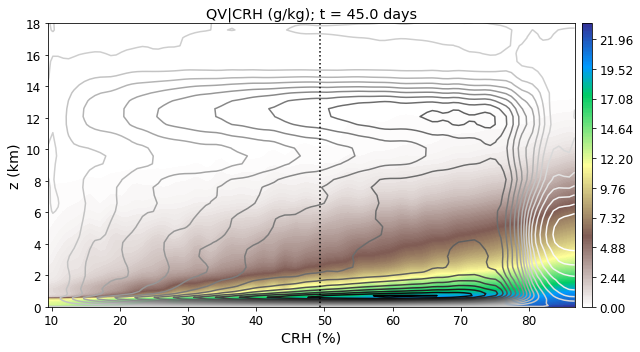

In [172]:
print("Make single movie")

# # condvar = 'W'
# condvar = 'QRAD'
condvar = 'QV'
refvar = 'CRH'
# refvar = 'PW'


print()
print(". %s | %s"%(condvar,refvar))

cdist = getattr(thismodule,"cdist_%s_on_%s"%(condvar,refvar))
phi = getattr(thismodule,"phi_%s"%refvar)
edge = getattr(thismodule,"edge_%s"%refvar)
movie_path = os.path.join(moviedir,simname,'%s_on_%s_and_circulation_dt%d.mp4'%(condvar,refvar,width))

fig,ax = plt.subplots(figsize=(9,5))
makeMovie(condvar,refvar,cdist,phi,movie_path,edge=edge,cmap = plt.cm.terrain_r)


Make movie

. W | PW
5, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 
. QRAD | PW
5, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 
. W | CRH
5, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 
. QRAD | CRH
5, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 

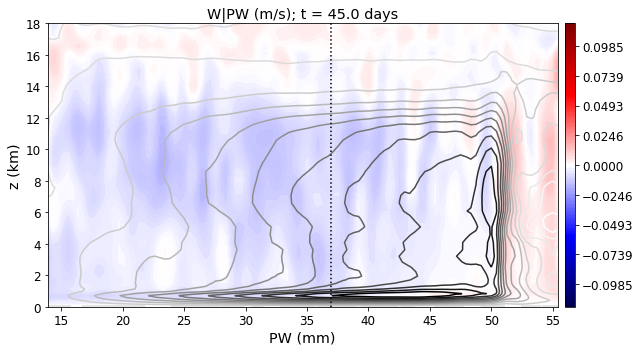

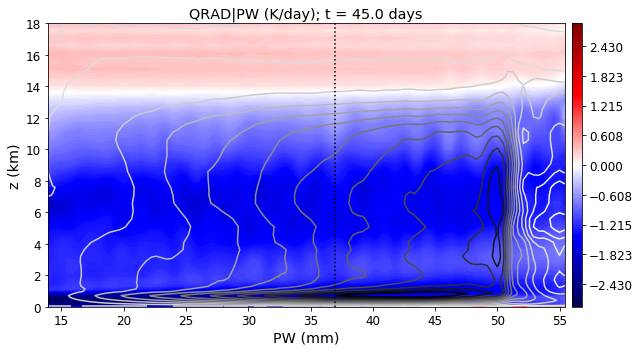

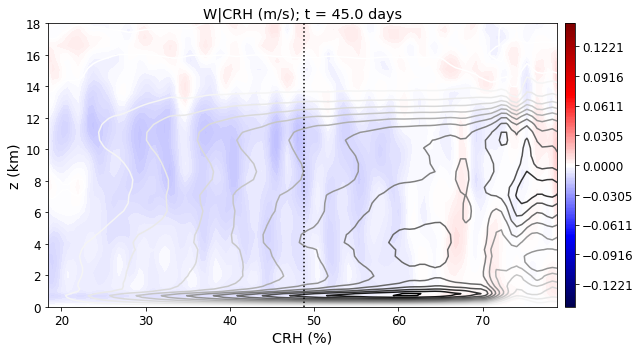

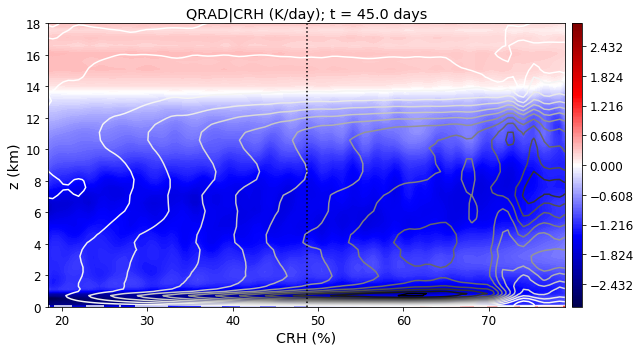

In [116]:
print("Make all movies")

for refvar in refvars:
    for condvar in condvars:
        
        print()
        print(". %s | %s"%(condvar,refvar))

        cdist = getattr(thismodule,"cdist_%s_on_%s"%(condvar,refvar))
        phi = getattr(thismodule,"phi_%s"%refvar)
        edge = getattr(thismodule,"edge_%s"%refvar)
        movie_path = os.path.join(moviedir,simname,'%s_on_%s_and_circulation_dt%d.mp4'%(condvar,refvar,width))

        fig,ax = plt.subplots(figsize=(9,5))
        makeMovie(condvar,refvar,cdist,phi,movie_path,edge=edge)
